# <center> Практика. Статистические тесты в контексте EDA

## <center> Постановка задачи <center>

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

Необходимо:

 - Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
 - А также ответить на ключевые вопросы HR-агентства:
    - Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    - Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    - Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    - Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Сразу выставим уровень значимости $\alpha=0.05$.

Ответить на эти вопросы нам помогут данные из датасета Data Science Job Salaries” (kaggle.com)

Данные содержат следующие столбцы:

* work_year	Год - в котором была выплачена зарплата.  
* experience_level - Опыт работы на этой должности в течение года:
    - EN — Entry-level/Junior;
    - MI — Mid-level/Intermediate;
    - SE — Senior-level/Expert;
    - EX — Executive-level/Director.
* employment_type - Тип трудоустройства для этой роли:
    - PT — неполный рабочий день;
    - FT — полный рабочий день;
    - CT — контракт;
    - FL — фриланс.
* job_title - Роль, в которой соискатель работал в течение года.
* salary - Общая выплаченная валовая сумма заработной платы.
* salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    - 0 — удалённой работы нет (менее 20 %);
    - 50 — частично удалённая работа;
    - 100 — полностью удалённая работа (более 80 %).
* company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* company_size - Среднее количество людей, работавших в компании в течение года:
    - S — менее 50 сотрудников (небольшая компания);
    - M — от 50 до 250 сотрудников (средняя компания);
    - L — более 250 сотрудников (крупная компания).

## Загрузка данных

In [7]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

In [2]:
# загружаем датасет
data = pd.read_csv('data/ds_salaries.csv')
data.head()

Unnamed: 0  work_year experience_level employment_type  \
0           0       2020               MI              FT   
1           1       2020               SE              FT   
2           2       2020               SE              FT   
3           3       2020               MI              FT   
4           4       2020               SE              FT   

                    job_title  salary salary_currency  salary_in_usd  \
0              Data Scientist   70000             EUR          79833   
1  Machine Learning Scientist  260000             USD         260000   
2           Big Data Engineer   85000             GBP         109024   
3        Product Data Analyst   20000             USD          20000   
4   Machine Learning Engineer  150000             USD         150000   

  employee_residence  remote_ratio company_location company_size  
0                 DE             0               DE            L  
1                 JP             0               JP            S  
2                 GB            50               GB            M  
3                 HN             0               HN            S  
4                 US            50               US            L

Т.к. у нас есть колонка salary_in_usd, в которой указана зп в долларах, это значительно упрощает дело, то есть не придется приводить зп к одной валюте, значит колонки salary и salary_currency нам не нужны, их можно удалить

In [8]:
data = data.drop(['salary', 'salary_currency'], axis=1)
data.head()

Unnamed: 0  work_year experience_level employment_type  \
0           0       2020               MI              FT   
1           1       2020               SE              FT   
2           2       2020               SE              FT   
3           3       2020               MI              FT   
4           4       2020               SE              FT   

                    job_title  salary_in_usd employee_residence  remote_ratio  \
0              Data Scientist          79833                 DE             0   
1  Machine Learning Scientist         260000                 JP             0   
2           Big Data Engineer         109024                 GB            50   
3        Product Data Analyst          20000                 HN             0   
4   Machine Learning Engineer         150000                 US            50   

  company_location company_size  
0               DE            L  
1               JP            S  
2               GB            M  
3               HN            S  
4               US            L

Отсортируем оставшиеся признаки

Категориальные:
 - experience_level
 - employment_type
 - job_title
 - remote_ratio
 - company_location
 - company_size
 
Количественные:
 - work_year
 - salary_in_usd

In [9]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## <center> Описательный анализ данных <center>

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary_in_usd       607 non-null    int64 
 6   employee_residence  607 non-null    object
 7   remote_ratio        607 non-null    int64 
 8   company_location    607 non-null    object
 9   company_size        607 non-null    object
dtypes: int64(4), object(6)
memory usage: 47.5+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [11]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 0


### ЗП в зависимости от года

In [30]:
mask = data['job_title'] == 'Data Scientist'
data_agg = data[mask].groupby('work_year')['salary_in_usd'] 

lineplot = sns.lineplot(data=data_agg)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

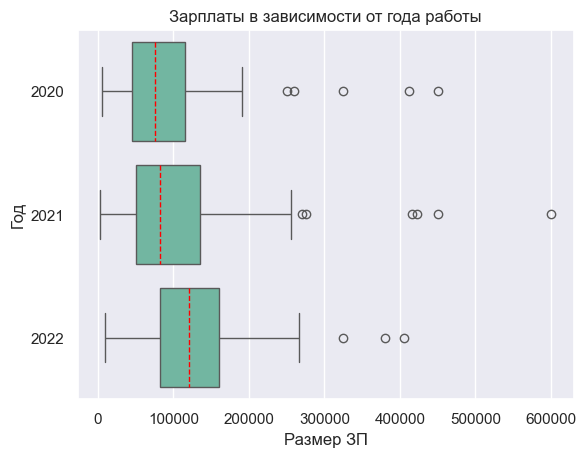

In [28]:
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер ЗП', ylabel='Год')
plt.title('Зарплаты в зависимости от года работы')
plt.show()

<Axes: >

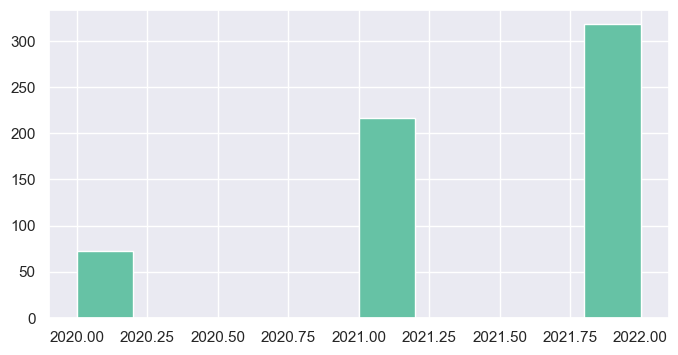

In [24]:
plt.figure(figsize=(8,4))
data['work_year'].hist()

<Axes: xlabel='work_year', ylabel='salary_in_usd'>

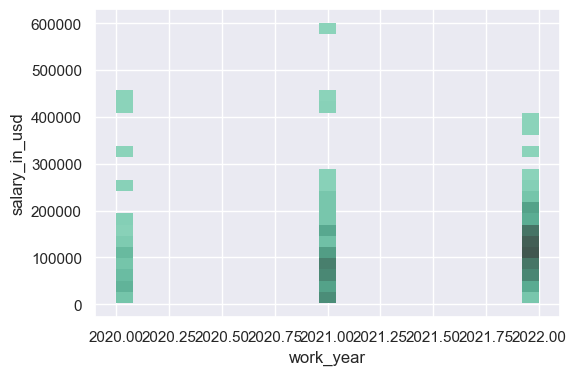

In [ ]:
fig, axes = plt.subplots(figsize=(6,4))
sns.histplot(
    data=data,
    x='work_year',
    y='salary_in_usd',
    bins=25
)

In [17]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер ЗП']
data_agg

Размер ЗП
count     607.00
mean   112297.87
std     70957.26
min      2859.00
25%     62726.00
50%    101570.00
75%    150000.00
max    600000.00

Визуально можно сказать, что данные распределены не нормально, имеются выбросы, в следующем разделе проведем статистические тесты

### Зарплаты Data Scientist и Data Engineer в 2022 году

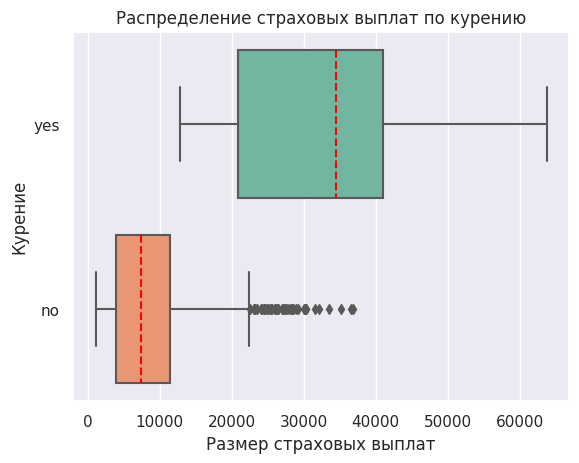

In [ ]:
ax = sns.boxplot(data, x='charges', y='smoker', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Курение')
plt.title('Распределение страховых выплат по курению')
plt.show()

In [18]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Страховые выплаты в зависимости от курения')
data_agg

Страховые выплаты в зависимости от курения


count       mean       std      min      25%       50%       75%  \
work_year                                                                     
2020        72.0   95813.00  82831.80   5707.0  45724.5   75544.0  115526.0   
2021       217.0   99853.79  80225.11   2859.0  50000.0   82528.0  135000.0   
2022       318.0  124522.01  58183.65  10000.0  81666.0  120000.0  160000.0   

                max  
work_year            
2020       450000.0  
2021       600000.0  
2022       405000.0

Распределения страховых выплат различны в зависимости от того, курит ли клиент. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Страховые выплаты в зависимости от региона

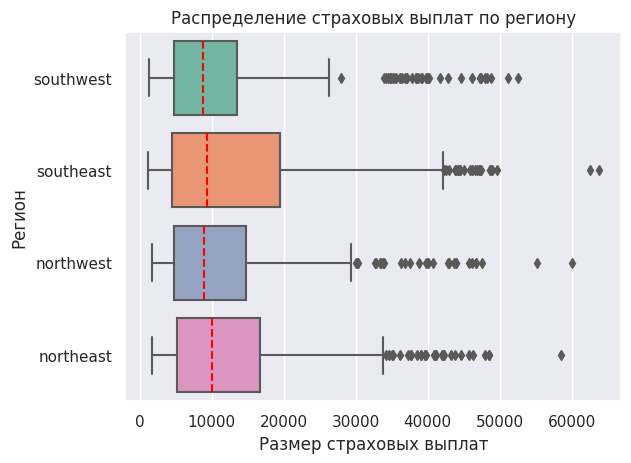

In [ ]:
ax = sns.boxplot(data, x='charges', y='region', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Размер страховых выплат', ylabel='Регион')
plt.title('Распределение страховых выплат по региону')
plt.show()

In [ ]:
data_agg = data.groupby('region')['charges'].describe().round(2)
print('Страховые выплаты в зависимости от региона')
data_agg

Страховые выплаты в зависимости от региона


count      mean       std      min      25%       50%       75%  \
region                                                                       
northeast  324.0  13406.38  11255.80  1694.80  5194.32  10057.65  16687.36   
northwest  324.0  12450.84  11073.13  1621.34  4733.64   8976.98  14788.75   
southeast  364.0  14735.41  13971.10  1121.87  4440.89   9294.13  19526.29   
southwest  325.0  12346.94  11557.18  1241.56  4751.07   8798.59  13462.52   

                max  
region               
northeast  58571.07  
northwest  60021.40  
southeast  63770.43  
southwest  52590.83

Распределения страховых выплат различны для разных регионов. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Соотношение курящих среди мужчин и женщин

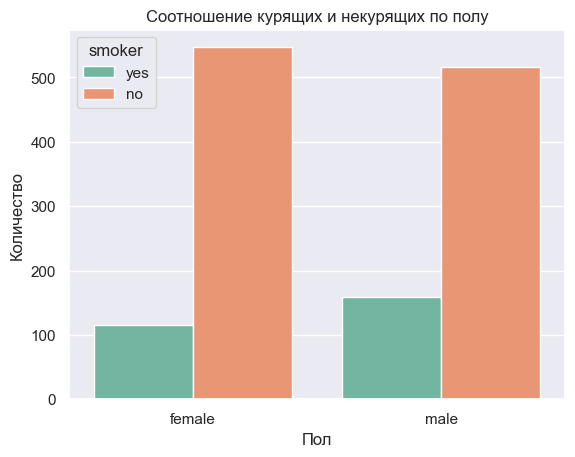

In [ ]:
ax = sns.countplot(data=data, x=data['sex'], hue='smoker')
ax.set(xlabel='Пол', ylabel='Количество')
plt.title('Соотношение курящих и некурящих по полу')
plt.show()

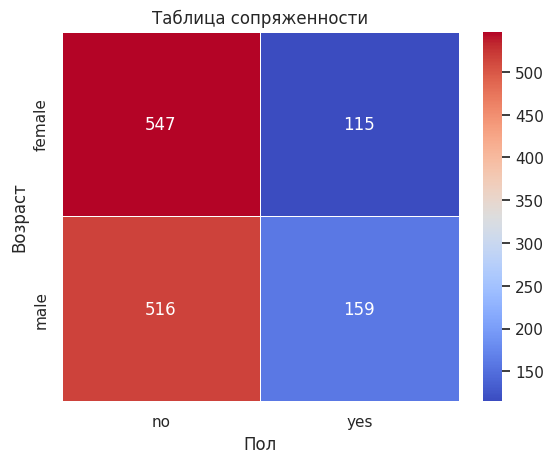

In [ ]:
cross_tab = pd.crosstab(index=data['sex'], columns=data['smoker'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Пол', ylabel='Возраст')
plt.title('Таблица сопряженности')
plt.show()

Согласно данным, среди курящих мужчин больше, чем женщин. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных



In [ ]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически меньше либо равен размеру страховых выплат клиентов-женщин ($μ_2$).

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат клиентов-мужчин ($μ_1$) статистически больше, чем размер страховых выплат клиентов-женщин ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [ ]:
# значения страховых выплат
charges_male = data.loc[data['sex']=='male', 'charges']
charges_female = data.loc[data['sex']=='female', 'charges']

# проводим тест Шапиро-Уилка
print('Для мужчин:')
result = stats.shapiro(charges_male)
decision_normality(result[1])

print('Для женщин:')
result = stats.shapiro(charges_female)
decision_normality(result[1])

Для мужчин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для женщин:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [ ]:
# проводим тест
_, p = stats.mannwhitneyu(charges_male, charges_female, alternative='greater')
decision_hypothesis(p)

p-value = 0.694
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что размер страховых выплат для клиентов-мужчин больше, чем для клиентов-женщин.

### Размер страховых выплат для некурящих клиентов меньше, чем для курящих?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически больше либо равен размеру страховых выплат для курящих клиентов ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер страховых выплат для некурящих клиентов ($μ_1$) статистически меньше, чем размер страховых выплат для курящих клиентов ($μ_2$).
$$ H_1 : μ_1 < μ_2$$




**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
charges_no_smoker = data.loc[data['smoker']=='no', 'charges']
charges_smoker = data.loc[data['smoker']=='yes', 'charges']

# проводим тест Шапиро-Уилка
print('Для некурящих клиентов:')
result = stats.shapiro(charges_no_smoker)
decision_normality(result[1])

print('Для курящих клиентов:')
result = stats.shapiro(charges_smoker)
decision_normality(result[1])

Для некурящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для курящих клиентов:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер страховых выплат»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать U-критерий Манна — Уитни.

**Проведём тест**


In [ ]:
# проводим тест
_, p = stats.mannwhitneyu(charges_no_smoker, charges_smoker, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Размер страховых выплат для некурящих клиентов меньше, чем для курящих.

### Влияет ли регион проживания на размер выплат?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: размер страховых выплат не отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза*: размер страховых выплат отличается в разных регионах: северо-восток ($μ_1$), юго-восток ($μ_2$), юго-запад ($μ_3$), северо-запад ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$



**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

In [ ]:
# значения страховых выплат
charges_northeast = data.loc[data['region']=='northeast', 'charges']
charges_southeast = data.loc[data['region']=='southeast', 'charges']
charges_northwest = data.loc[data['region']=='northwest', 'charges']
charges_southwest = data.loc[data['region']=='southwest', 'charges']

# проводим тест Шапиро-Уилка
print('Для северо-востока:')
result = stats.shapiro(charges_northeast)
decision_normality(result[1])

print('Для юго-востока:')
result = stats.shapiro(charges_southeast)
decision_normality(result[1])

print('Для северо-запада:')
result = stats.shapiro(charges_northwest)
decision_normality(result[1])

print('Для юго-запада:')
result = stats.shapiro(charges_southwest)
decision_normality(result[1])


Для северо-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-востока:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для северо-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Для юго-запада:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Регион проживания в США»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет. 

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [ ]:
# проводим тест
_, p = stats.kruskal(charges_northeast, charges_southeast, charges_southwest, charges_northwest)
decision_hypothesis(p)

p-value = 0.202
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**

Нет оснований утверждать, что есть разница в размере страховых выплат в разных регионах.

### Есть ли взаимосвязь между курением и полом?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между тем, курит человек или нет, и его полом нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между тем, курит человек или нет, и его полом есть взаимосвязь (признаки зависимы).


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Пол»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [ ]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(data['sex'], data['smoker'])

cross_table

smoker   no  yes
sex             
female  547  115
male    516  159

In [ ]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.006
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

Существует статистически значимая взаимосвязь между полом и курением.

## Итоговые результаты исследования

*   Нет оснований утверждать, что есть разница в размере страховых выплат для клиентов-мужчин и клиентов-женщин.
*   Размер страховых выплат для некурящих клиентов меньше, чем для курящих.
*   Нет оснований утверждать, что есть разница в размере страховых выплат для разных регионов.
*   Существует взаимосвязь между полом и курением.